# Selective withdrawal overzicht

In [11]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 15})
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
from scipy.optimize import fsolve, root, curve_fit
import csv
import pandas as pd
from IPython.display import Image
import progressbar
import os


In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def inch2m(inch):
    return inch * 0.0254

def m2inch(m):
    return m/0.0254

def loadcsvfile(filename, path='data/', delimiter=';'):
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

### Data van verschillende papers

In [3]:
# Harleman & Elder
HaEl1 = loadcsvfile('Harleman_Elder_1.xlsx')
HaEl2 = loadcsvfile('Harleman_Elder_2.xlsx')
# Noordland proeven (M1204)
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
#Noordland referentieproeven met delta_rho = 2
sel = np.arange(47)
NL1204ref = NL1204.iloc[sel]

# IJmuiden paper
IJ = loadcsvfile('IJmuiden.xlsx')

Yu = loadcsvfile('Yu.xlsx')

### Constantes

In [4]:
g = 9.81 # [m s^-2] gravitatieversnelling
rho_1 = 1000 # [kg m^-3] dichtheid zoet water
rho_2 = 1022 # [kg m^-3] dichtheid zout water
Drho = rho_2 - rho_1 # [kg m^-3] dichtheidsverschil
eps = Drho/rho_2
gp = eps*g

### Height of layers

In [5]:
H_T = 1
H2 = 0.5
H1 = H_T - H2

### Equations Islam et al. (2018)

$$F_r = \frac{q}{\sqrt{g'H_2^3}}$$\
$$F_1^2 = \frac{q_1^2}{g'h_1^3}$$\
$$F_2^2 = \frac{q_2^2}{g'h_2^3}$$\
$$F_1^2 = \left( 1-\epsilon F_1^2 \right)\left( 1-F_2^2 \right)$$\
$$\epsilon F_1^2 = \frac{H_1}{h_1} + \frac{H_2}{h_1} - \frac{h_2}{h_1} - 1$$\
$$\frac{1}{2}F_2^2 - \frac{1}{2}F_1^2 \frac{h_1}{h_2} + 1 = \frac{H_2}{h_2}$$\
The values for $F_2^2$, $h_1$, $h_2$, $q_1$ and $q_2$ can be calculated for any given values of $F_1^2$, $H_1$ and $H_2$.

Using above equations, this gives: \
$$F_2^2 = 1 - \frac{F_1^2}{1-\epsilon F_1^2}$$ \
$$h_2 = \frac{F_1^2\left(H_2+H_1+2H_2\epsilon\right)+2H_2}{F_1^2\left(1+\epsilon\left(F_2^2+2\right)\right)+F_2^2+2}$$ \
$$h_1 = \frac{H_1\left(2+F_2^2\right)+H_2 F_2^2}{2+F_2^2+F_1^2\left(1+\epsilon\left(2+F_2^2\right)\right)}$$\
$$q_1 = \sqrt{F_1^2 g' h_1^3}$$\
$$q_2 = \sqrt{F_2^2 g' h_2^3}$$

from which $\lambda$ and the Froude number $F_r$ can be found:\
$$\lambda = \frac{q_1}{q} = \frac{q_1}{q_1+q_2}$$\
$$F_r = \sqrt{\frac{q^2}{g'H_2^3}} = \sqrt{\frac{\left(q_1+q_2\right)^2}{g'H_2^3}}$$

In [6]:
def solveIslam(F1s,H1=H1,H2=H2):
    #F2s = 1-F1s/(1-eps*F1s)
    #h2 = ( F1s*(H2+H1+2*H2*eps)+2*H2 ) / ( F1s*(1+eps*(F2s+2))+F2s+2 )
    #h1 = ( H1*(2+F2s)+H2*F2s ) / ( 2+F2s+F1s*(1+eps*(2+F2s)) )
    F2s = 1-F1s
    h2 = ( F1s*(H2+H1)+2*H2 ) / ( F1s+F2s+2 )
    h1 = ( H1*(2+F2s)+H2*F2s ) / ( 2+F2s+F1s )
    q1 = np.sqrt(F1s*gp*h1**3)
    q2 = np.sqrt(F2s*gp*h2**3)
    lam = q1/(q1+q2)
    Fr = (q1+q2)/np.sqrt(gp*H2**3)
    return F2s, h1, h2, q1, q2, lam, Fr

### Incipient case: 
$q_1 = 0 \rightarrow F_1^2 = 0$ \
From the above equations, this gives: \
$F_2^2 = 1$\
$h_2 = \frac{2}{3}H_2$\
$h_1 = H_1 + \frac{H_2}{3}$\
$\lambda = 0$\
$F_r = \left(\frac{2}{3}\right)^{\frac{3}{2}} \approx 0.544$

In [7]:
incipient = solveIslam(F1s=0)
print(r'F2s={0}, h1={1}, h2={2}'.format(incipient[0],incipient[1],incipient[2]))
print(r'q1={0}, q2={1}, lam={2}, Fr={3}'.format(incipient[3],incipient[4],incipient[5],incipient[6]))

F2s=1, h1=0.6666666666666666, h2=0.3333333333333333
q1=0.0, q2=0.08843791886118967, lam=0.0, Fr=0.5443310539518172


### Maximum selective withdrawal (for $H_2/H_T = 0.5$):
$F_1^2 = 0.5$\
Using above equations, this gives:

In [8]:
selective_max = solveIslam(F1s=0.5)
print(r'F2s={0}, h1={1}, h2={2}'.format(selective_max[0],selective_max[1],selective_max[2]))
print(r'q1={0}, q2={1}, lam={2}, Fr={3}'.format(selective_max[3],selective_max[4],selective_max[5],selective_max[6]))

F2s=0.5, h1=0.5, h2=0.5
q1=0.11488422658742582, q2=0.11488422658742582, lam=0.5, Fr=1.4142135623730951


### Now for all values between $0\leq F_1^2 \leq 0.5$ (for $H_2/H_T = 0.5$):

In [9]:
F1s_arr = np.linspace(0,1,500000)
f = pd.DataFrame({'F1s': F1s_arr,
                  'F2s': np.zeros(len(F1s_arr)),
                  'h1': np.zeros(len(F1s_arr)),
                  'h2': np.zeros(len(F1s_arr)),
                  'q1': np.zeros(len(F1s_arr)),
                  'q2': np.zeros(len(F1s_arr)),
                  'Fr': np.zeros(len(F1s_arr)),
                  'lam': np.zeros(len(F1s_arr))})

sol = solveIslam(F1s_arr, H1=H1, H2=H2)
f.F2s, f.h1, f.h2, f.q1, f.q2, f.lam, f.Fr = sol

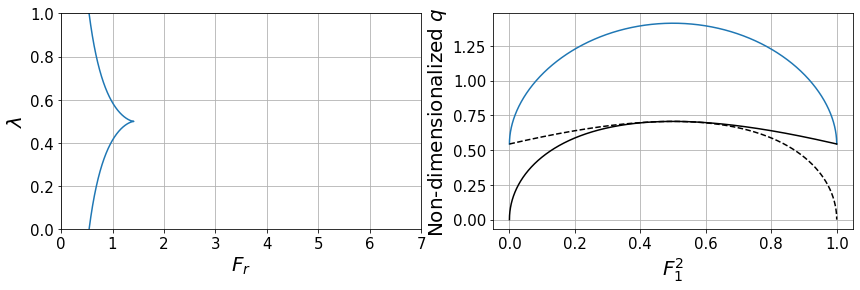

In [12]:
figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='')
ax.axis([0,7,0,1])
ax.grid()
ax.plot(f.Fr, f.lam)

bx = plt.axes([0.6, 0, .5, .5])
bx.set(xlabel='$F_1^2$', ylabel='Non-dimensionalized $q$', title='')
bx.grid()
bx.plot(f.F1s, f.Fr)
bx.plot(f.F1s, f.q1/np.sqrt(gp*H2**3), 'k')
bx.plot(f.F1s, f.q2/np.sqrt(gp*H2**3), '--k')

plt.show()

### Now recreate Jirka figure 3
In Jirka, for a given $H_2/H_T$, $F_{r_{max}}$ can be calculated (NOTE: this is for very small $\epsilon$ and $F_1$) by\
$F_{r_{max}} = \left( \frac{H}{H_2} \right)^{5/2} \left( 1+\sqrt{\frac{H}{H_2}-1} \right)^{-2}$

In [13]:
ff = pd.DataFrame({})

H2_arr = np.array([0.25, 0.375, 0.5, 0.625, 0.75])
F1s_arr = np.linspace(0,1,500000)

for H2 in progressbar.progressbar(H2_arr):
    H1 = H_T - H2
    f = pd.DataFrame({'F1s': F1s_arr,
                      'F2s': np.zeros(len(F1s_arr)),
                      'h1': np.zeros(len(F1s_arr)),
                      'h2': np.zeros(len(F1s_arr)),
                      'q1': np.zeros(len(F1s_arr)),
                      'q2': np.zeros(len(F1s_arr)),
                      'Fr': np.zeros(len(F1s_arr)),
                      'lam': np.zeros(len(F1s_arr)),
                      'H2': np.ones(len(F1s_arr))*H2})

    sol = solveIslam(F1s_arr, H1=H1, H2=H2)
    f.F2s, f.h1, f.h2, f.q1, f.q2, f.lam, f.Fr = sol
    ff = ff.append(f)

100% (5 of 5) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


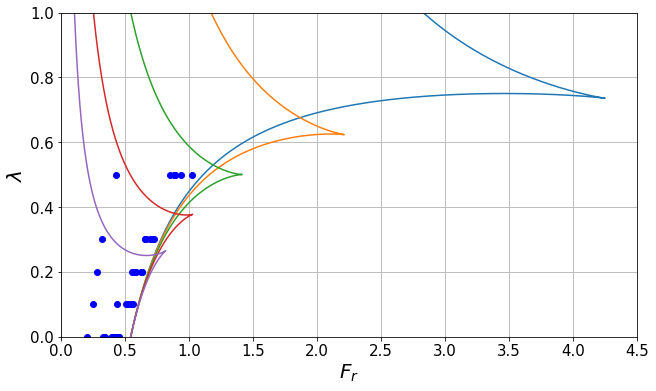

In [14]:
figprops = dict(figsize=(16, 9), dpi=72)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='')
ax.axis([0,4.5,0,1])
ax.grid()
[ax.plot(ff.Fr[ff.H2==H2], ff.lam[ff.H2==H2]) for H2 in H2_arr]

ax.plot(NL1204ref.Fr, NL1204ref.lam, 'ob')

plt.show()

# Fan

Fan stappenplan:
1) $K$ estimated according to outlet type ($K\approx1.5$ for bottom slot);
2) $h_L$ obtained through $K=Gh_L=g'^{\frac{1}{3}}h_L/q^{\frac{2}{3}}$;
3) use figure 9 from Fan (2008) to estimate $a$;
4) use $c_0/c_2 = a-bGy$, with $b=1/(2K)$.

Example on the data of Yu (2004 (see paragraph "Description of typical experiments"):\
$C_i=17.3$ g/L $\rightarrow g' \approx 0.17$ m/s$^2$\
$q_0 = 37.67$ cm$^2$/s\
$Z_0/H = 0.4 \rightarrow P = 16.125$ cm\
$K=0.53 \rightarrow b=\frac{1}{2K}=0.94$ (from Fan table I)
$h_L = Kq_0^{\frac{2}{3}}/g'^{\frac{1}{2}} = 9.75$ cm\
$\frac{P}{h_L}-1 = 0.654 \rightarrow a = 0.52$ (from Fan figure 9)\
$\frac{c_0}{c_2} = a - bGy$\
NOTE: in Fan, $y$ is defined positive downwards

In the figure below, the data points of Yu (2004) are plotted as well as the predicted $c_0/c_2$. The predicted line (blue) is not the best fit through the data points. When a linear fit is performed (red line), another value for $b$ is found, i.e. $b=0.78$, which corresponds to $K=0.64$. The values for $a$ remains (approximately) the same.

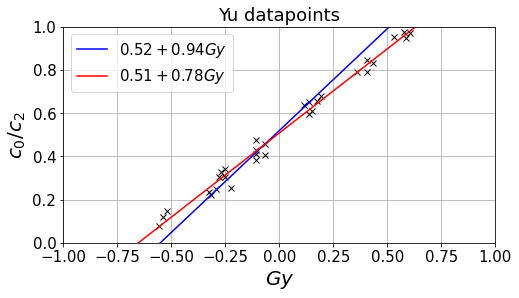

In [16]:
figprops = dict(figsize=(12, 6), dpi=72)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title='Yu datapoints')
ax.axis([-1,1,0,1])
ax.grid()

ax.plot(Yu.Gy, Yu.c0_f_c2, 'xk')

a = 0.52
b = 1/(2*0.53)
Gy = np.linspace(-10,10,10000)
c0c2 = a + b*Gy
ax.plot(Gy, c0c2, 'b', label="${0:.2f} + {1:.2f}Gy$".format(a, b))

p = np.polyfit(Yu.Gy, Yu.c0_f_c2, 1)
ax.plot(Gy, p[0]*Gy + p[1], 'r', label="${0:.2f} + {1:.2f}Gy$".format(p[1], p[0]))

ax.legend()
plt.show()

# Noordland data

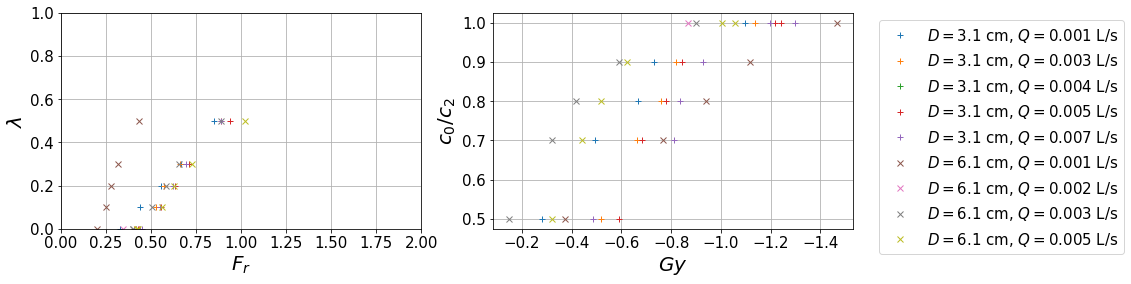

In [17]:
NL1204D3Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q4 = NL1204ref[(NL1204ref.Q==4e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q6 = NL1204ref[(NL1204ref.Q==6e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q7 = NL1204ref[(NL1204ref.Q==7e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q8 = NL1204ref[(NL1204ref.Q==8e-3) & (NL1204ref.D==3.1e-2)]

NL1204D6Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==6.1e-2)]

reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]

figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$F_r$", ylabel=r'$\lambda$', title='')
ax.axis([0,2,0,1])
ax.grid()

ax.plot(NL1204D3Q1.Fr, NL1204D3Q1.lam, '+', label="$D=3.1$ cm, $Q=0.001$ L/s")
#ax.plot(NL1204D3Q2.Fr, NL1204D3Q2.lam, '+', label="$D=3.1$ cm, $Q=0.002$ L/s") #zijn maar 2 datapunten op lam=0
ax.plot(NL1204D3Q3.Fr, NL1204D3Q3.lam, '+', label="$D=3.1$ cm, $Q=0.003$ L/s")
ax.plot(NL1204D3Q4.Fr, NL1204D3Q4.lam, '+', label="$D=3.1$ cm, $Q=0.004$ L/s")
ax.plot(NL1204D3Q5.Fr, NL1204D3Q5.lam, '+', label="$D=3.1$ cm, $Q=0.005$ L/s")
#ax.plot(NL1204D3Q6.Fr, NL1204D3Q6.lam, '+', label="$D=3.1$ cm, $Q=0.006$ L/s") #is maar 1 datapunt
ax.plot(NL1204D3Q7.Fr, NL1204D3Q7.lam, '+', label="$D=3.1$ cm, $Q=0.007$ L/s")
#ax.plot(NL1204D3Q8.Fr, NL1204D3Q8.lam, '+', label="$D=3.1$ cm, $Q=0.008$ L/s") #zijn maar 2 datapunten op lam=0

ax.plot(NL1204D6Q1.Fr, NL1204D6Q1.lam, 'x', label="$D=6.1$ cm, $Q=0.001$ L/s")
ax.plot(NL1204D6Q2.Fr, NL1204D6Q2.lam, 'x', label="$D=6.1$ cm, $Q=0.002$ L/s")
ax.plot(NL1204D6Q3.Fr, NL1204D6Q3.lam, 'x', label="$D=6.1$ cm, $Q=0.003$ L/s")
ax.plot(NL1204D6Q5.Fr, NL1204D6Q5.lam, 'x', label="$D=6.1$ cm, $Q=0.005$ L/s")

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

bx = plt.axes([.6, 0, .5, .5])
bx.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title='')
#bx.axis([0,2,0,1])
bx.grid()

bx.plot(NL1204D3Q1.G*(NL1204D3Q1.D/2-NL1204D3Q1.am), 1-NL1204D3Q1.lam, '+', label="$D=3.1$ cm, $Q=0.001$ L/s")
#bx.plot(NL1204D3Q2.G*(NL1204D3Q2.D/2-NL1204D3Q2.am), 1-NL1204D3Q2.lam, '+', label="$D=3.1$ cm, $Q=0.002$ L/s") #zijn maar 2 datapunten op lam=0
bx.plot(NL1204D3Q3.G*(NL1204D3Q3.D/2-NL1204D3Q3.am), 1-NL1204D3Q3.lam, '+', label="$D=3.1$ cm, $Q=0.003$ L/s")
bx.plot(NL1204D3Q4.G*(NL1204D3Q4.D/2-NL1204D3Q4.am), 1-NL1204D3Q4.lam, '+', label="$D=3.1$ cm, $Q=0.004$ L/s")
bx.plot(NL1204D3Q5.G*(NL1204D3Q5.D/2-NL1204D3Q5.am), 1-NL1204D3Q5.lam, '+', label="$D=3.1$ cm, $Q=0.005$ L/s")
#bx.plot(NL1204D3Q6.G*(NL1204D3Q6.D/2-NL1204D3Q6.am), 1-NL1204D3Q6.lam, '+', label="$D=3.1$ cm, $Q=0.006$ L/s") #is maar 1 datapunt
bx.plot(NL1204D3Q7.G*(NL1204D3Q7.D/2-NL1204D3Q7.am), 1-NL1204D3Q7.lam, '+', label="$D=3.1$ cm, $Q=0.007$ L/s")
#bx.plot(NL1204D3Q8.G*(NL1204D3Q8.D/2-NL1204D3Q8.am), 1-NL1204D3Q8.lam, '+', label="$D=3.1$ cm, $Q=0.008$ L/s") #zijn maar 2 datapunten op lam=0

bx.plot(NL1204D6Q1.G*(NL1204D6Q1.D/2-NL1204D6Q1.am), 1-NL1204D6Q1.lam, 'x', label="$D=6.1$ cm, $Q=0.001$ L/s")
bx.plot(NL1204D6Q2.G*(NL1204D6Q2.D/2-NL1204D6Q2.am), 1-NL1204D6Q2.lam, 'x', label="$D=6.1$ cm, $Q=0.002$ L/s")
bx.plot(NL1204D6Q3.G*(NL1204D6Q3.D/2-NL1204D6Q3.am), 1-NL1204D6Q3.lam, 'x', label="$D=6.1$ cm, $Q=0.003$ L/s")
bx.plot(NL1204D6Q5.G*(NL1204D6Q5.D/2-NL1204D6Q5.am), 1-NL1204D6Q5.lam, 'x', label="$D=6.1$ cm, $Q=0.005$ L/s")

bx.invert_xaxis()
bx.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

For each dataset (e.g. D=3.1cm, Q=1,3,5,7 L/s) plot $c_0/c_2$ on the y-axis and $Gy$ on the x-axis, with:
$$\frac{c_0}{c_2} = 1-\lambda,$$
$$G = \frac{g'^{\frac{1}{3}}}{q^{\frac{2}{3}}},$$
$$y = P-h_0,$$
with the elevation of the outlet center $P=D/2$ and $h_0$ the height of the interface, which is either $h_r$ or $a_m$ (decide which is better to use... first, I will continue with $a_m$).\
This is done for one dataset in the figure below. A linear trend line can be fitted through the data points, giving the values of $a$ and $b$ of the equation from Fan, i.e. $c_0/c_2 = a - bGy$. In the case of $D=3.1$ cm and $Q=1$ L/s, this gives $a=0.27$ and $b=0.84$.

mean G = 42.956646768638564
a = 0.2695939565627949
b = 0.8397248977809715
hL = 0.013861256544502615


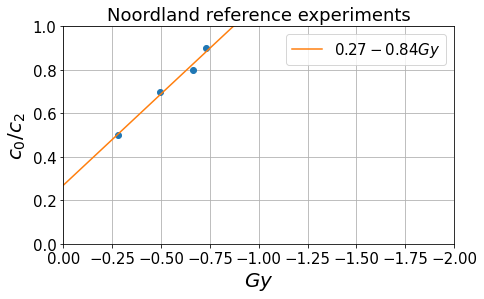

In [18]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments")
ax.axis([-2,0,0,1])
ax.grid()

NL1204sel = NL1204D3Q1.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
P = NL1204sel.iloc[0].D/2
G = NL1204sel.G
print('mean G =', np.mean(G))
y = NL1204sel.D/2 - NL1204sel.am
Gy = G*y
c0c2 = 1 - NL1204sel.lam

Gyfit = np.linspace(-4,3,1000)
#in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
p = np.polyfit(Gy, c0c2, 1)
[a, b] = p[1], abs(p[0])
c0c2fit = a - b*Gyfit
print('a =', a)
print('b =', b)
hL = 1/(2*np.mean(G)*b)
print('hL =', hL)

ax.plot(Gy, c0c2, 'o')
ax.plot(Gyfit, c0c2fit, label="${0:.2f}-{1:.2f}Gy$".format(a,b))

ax.legend()
ax.invert_xaxis()
plt.show()

In above example ($D=3.1$ cm, $Q=1$ L/s) $P>h_L$, which is not always the case. If $P<h_L$, a coordination transformation is needed according to Fan and coordinate $y$ becomes $y'=y+(d-2P)$, with $d=2h_L$. This is the case for, for example, $D=3.1$ cm and $Q=3$ L/s. In the figure below, you can see again $c_0/c_2$ versus $Gy$, for both the observed values and the adjusted values after transformation.\
\
Comparing the values for $a$ and $b$ of the one above ($D=3.1$ cm, $Q=1$ L/s) and the one below ($D=3.1$ cm, $Q=3$ L/s), you see that they are quite different from each other ($b=0.84$ and $b=1.3$, respectively) and therefore the value of $K$ is different in both cases as $K=1/(2b)$. It is expected (from the theory of Fan) that $K$ is constant for a bottom slot in a vertical wall, so you only might expect a change in $K$ when something in the wall is changed, for example changing the value of $D$.

In [19]:
def transform(Gy, G, hL, P):
    return Gy + 2*G*(hL-P)

mean G = 20.8391828166878
a = -0.1629361064396214
b = 1.2895962823287141
hL = 0.018605251593429982
a' = -0.0026875326747152176
b' = 1.301495977777912


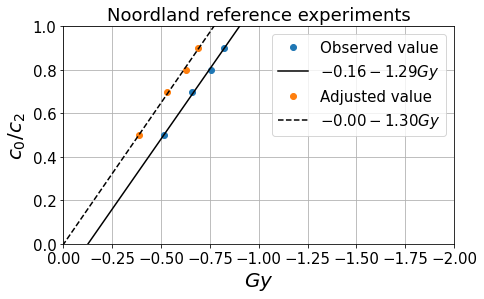

In [20]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments")
ax.axis([-2,0,0,1])
ax.grid()

NL1204sel = NL1204D3Q3.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
P = NL1204sel.iloc[0].D/2
G = NL1204sel.G
print('mean G =', np.mean(G))
y = NL1204sel.D/2 - NL1204sel.am
Gy = G*y
c0c2 = 1 - NL1204sel.lam

Gyfit = np.linspace(-4,3,1000)
#in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
p = np.polyfit(Gy, c0c2, 1)
[a, b] = p[1], abs(p[0])
c0c2fit = a - b*Gyfit
print('a =', a)
print('b =', b)
hL = 1/(2*np.mean(G)*b)
print('hL =', hL)

ax.plot(Gy, c0c2, 'o', label="Observed value")
ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$".format(a,b))

if P<hL:
    Gyp = transform(Gy, G, hL, P)
    pp = np.polyfit(Gyp, c0c2, 1)
    [ap, bp] = pp[1], abs(pp[0])
    c0c2fitp = ap - bp*Gyfit
    print("a' =", ap)
    print("b' =", bp)
    #Adjusted values according to transformation
    ax.plot(Gyp, c0c2, 'o', label="Adjusted value")
    ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy$".format(ap,bp))

ax.legend()
ax.invert_xaxis()
plt.show()

Making these plots for all sets of the reference data:

In [21]:
i = 0
for dataset in reference_data:
    plt.clf()
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments {0}-{1}".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    ax.axis([-2,1,0,1])
    ax.grid()

    NL1204sel = dataset.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
    P = NL1204sel.iloc[0].D/2
    G = NL1204sel.G
    y = NL1204sel.D/2 - NL1204sel.am
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)
    #in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
    p = np.polyfit(Gy, c0c2, 1)
    [a, b] = p[1], abs(p[0])
    c0c2fit = a - b*Gyfit
    hL = 1/(2*np.mean(G)*b)

    ax.plot(Gy, c0c2, 'o', label="Observed value")
    ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$".format(a,b))

    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        pp = np.polyfit(Gyp, c0c2, 1)
        [ap, bp] = pp[1], abs(pp[0])
        c0c2fitp = ap - bp*Gyfit
        #Adjusted values according to transformation
        ax.plot(Gyp, c0c2, 'o', label="Adjusted value")
        ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy$".format(ap,bp))

    ax.legend()
    ax.invert_xaxis()
    plt.savefig("figures/varying_K/using_am/{0}-{1}.png".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    plt.close()
    i += 1

<Figure size 432x288 with 0 Axes>

The next step is to do this for all datasets of Noordland (referentieproeven 1-47) and extract for each the values of $a$ and $P/h_L-1$ and plot ,just like they did in Fan figure 9, coefficient $a$ versus $P/h_L-1$.

In [22]:
coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data))})

i = 0
for dataset in reference_data:
    NL1204sel = dataset.iloc[1:]
    #NL1204sel = NL1204D3Q3.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
    P = NL1204sel.iloc[0].D/2
    G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
    y = NL1204sel.D/2 - NL1204sel.am
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)
    #in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
    p = np.polyfit(Gy, c0c2, 1)
    [a, b] = p[1], abs(p[0])
    hL = 1/(2*np.mean(G)*b)

    coeffa.P[i] = P
    coeffa.hL[i] = hL
    coeffa.a[i] = a
    coeffa.b[i] = b
    
    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        pp = np.polyfit(Gyp, c0c2, 1)
        [ap, bp] = pp[1], abs(pp[0])
        coeffa.a[i] = ap
        coeffa.b[i] = bp
    
    i += 1

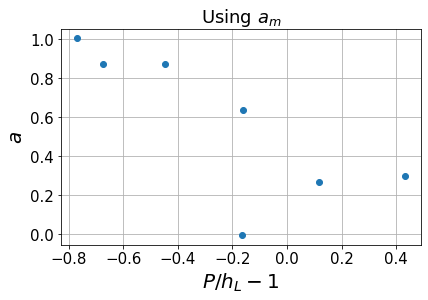

In [23]:
figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)
ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$P/h_L-1$", ylabel=r'$a$', title=r"Using $a_m$")
#ax.axis([-2,0,0,1])
ax.grid()

ax.plot(coeffa.P/coeffa.hL-1, coeffa.a, 'o')

plt.show()

Now if the same is done but using $h_r$ instead of $a_m$, the following figure is obtained:

In [24]:
i = 0
for dataset in reference_data:
    plt.clf()
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments {0}-{1}".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    ax.axis([-2,1,0,1])
    ax.grid()

    NL1204sel = dataset.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
    P = NL1204sel.iloc[0].D/2
    G = NL1204sel.G
    y = NL1204sel.D/2 - NL1204sel.hr
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)
    #in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
    p = np.polyfit(Gy, c0c2, 1)
    [a, b] = p[1], abs(p[0])
    c0c2fit = a - b*Gyfit
    hL = 1/(2*np.mean(G)*b)

    ax.plot(Gy, c0c2, 'o', label="Observed value")
    ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$".format(a,b))

    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        pp = np.polyfit(Gyp, c0c2, 1)
        [ap, bp] = pp[1], abs(pp[0])
        c0c2fitp = ap - bp*Gyfit
        #Adjusted values according to transformation
        ax.plot(Gyp, c0c2, 'o', label="Adjusted value")
        ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy$".format(ap,bp))

    ax.legend()
    ax.invert_xaxis()
    plt.savefig("figures/varying_K/using_hr/{0}-{1}.png".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    plt.close()
    i += 1

<Figure size 432x288 with 0 Axes>

In [25]:
coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data))})

i = 0
for dataset in reference_data:
    NL1204sel = dataset.iloc[1:]
    #NL1204sel = NL1204D3Q3.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
    P = NL1204sel.iloc[0].D/2
    G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
    y = NL1204sel.D/2 - NL1204sel.hr
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)
    #in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
    p = np.polyfit(Gy, c0c2, 1)
    [a, b] = p[1], abs(p[0])
    hL = 1/(2*np.mean(G)*b)

    coeffa.P[i] = P
    coeffa.hL[i] = hL
    coeffa.a[i] = a
    coeffa.b[i] = b
    
    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        pp = np.polyfit(Gyp, c0c2, 1)
        [ap, bp] = pp[1], abs(pp[0])
        coeffa.a[i] = ap
        coeffa.b[i] = bp
    
    i += 1

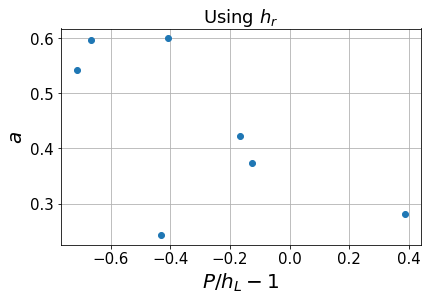

In [26]:
figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)
ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$P/h_L-1$", ylabel=r'$a$', title=r"Using $h_r$")
#ax.axis([-2,0,0,1])
ax.grid()

ax.plot(coeffa.P/coeffa.hL-1, coeffa.a, 'o')

plt.show()

# Keeping $K$ constant
Above, the value of $b$ was different in each set of data, but it is expected that $K$ remains constant for a bottom slot in a vertical wall. Therefore, in the next calculations, $K$ is set constant, so $b$ remains constant as well. Using scipy.optimize curve_fit (instead of numpy's polyfit), this constant $b$ is used to linearly fit a line through the datapoints to determine the value of $a$.

In [32]:
def func(x, a):
    return a - b*x

In [33]:
coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data))})

K = 0.4
b = 1/(2*K)

i = 0 #counter
for dataset in reference_data:
    plt.clf()
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments {0}-{1}".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    ax.axis([-2,1,0,1])
    ax.grid()
    NL1204sel = dataset.iloc[1:]
    #NL1204sel = NL1204D3Q3.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
    P = NL1204sel.iloc[0].D/2
    G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
    y = NL1204sel.D/2 - NL1204sel.am
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)
    #in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
    a = curve_fit(func, Gy, c0c2)[0][0]
    c0c2fit = a - b*Gyfit
    #p = np.polyfit(Gy, c0c2, 1)
    #[a, b] = p[1], abs(p[0])
    hL = 1/(2*np.mean(G)*b)
    
    ax.plot(Gy, c0c2, 'o', label="Observed value")
    ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$".format(a,b))

    coeffa.P[i] = P
    coeffa.hL[i] = hL
    coeffa.a[i] = a
    coeffa.b[i] = b
    
    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        ap = curve_fit(func, Gyp, c0c2)[0][0]
        c0c2fitp = ap - b*Gyfit
        #pp = np.polyfit(Gyp, c0c2, 1)
        #[ap, bp] = pp[1], abs(pp[0])
        coeffa.a[i] = ap
        coeffa.b[i] = b
        
        ax.plot(Gyp, c0c2, 'o', label="Adjusted value")
        ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy$".format(ap,b))

    ax.legend()
    ax.invert_xaxis()
    plt.savefig("figures/constant_K/using_am/{0}-{1}.png".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    plt.close()
    i += 1

<Figure size 432x288 with 0 Axes>

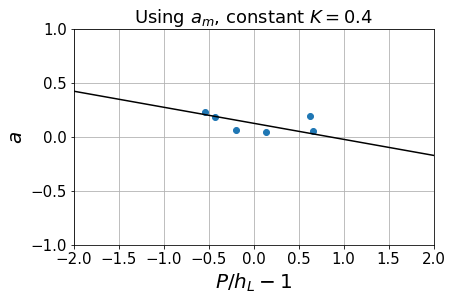

In [29]:
figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)
ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$P/h_L-1$", ylabel=r'$a$', title=r"Using $a_m$, constant $K={}$".format(K))
ax.axis([-2,2,-1,1])
ax.grid()

xfit = np.linspace(-20,20,1000)
p = np.polyfit(coeffa.P/coeffa.hL-1, coeffa.a, 1)
afit = p[0]*xfit+p[1]

ax.plot(coeffa.P/coeffa.hL-1, coeffa.a, 'o')
ax.plot(xfit,afit,'k')
#ax.plot(P/hL-1, a_predict, 'o')

plt.show()

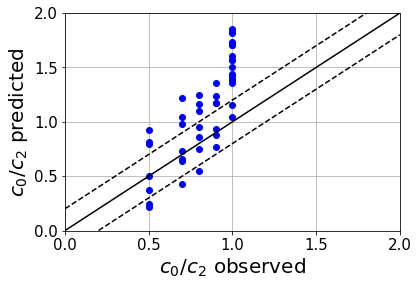

In [30]:
NL1204sel = NL1204ref
G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
P = NL1204sel.D/2
hL = 1/(2*G*b)
a_predict = np.interp(P/hL-1,xfit,afit)

c0c2comp = a_predict - b*G*(P-NL1204sel.am)
plt.plot(1-NL1204sel.lam, c0c2comp, 'ob')

plt.gca().axline((1, 1), slope=1, color='k')
plt.gca().axline((1.2, 1), slope=1, linestyle='--', color='k')
plt.gca().axline((1, 1.2), slope=1, linestyle='--', color='k')

plt.gca().set(xlabel="$c_0/c_2$ observed", ylabel="$c_0/c_2$ predicted")
plt.axis([0,2,0,2])
plt.grid()

### Using $h_r$

In [31]:
reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]
coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data))})

K = 0.4
b = 1/(2*K)

i = 0 #counter
for dataset in reference_data:
    plt.clf()
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments {0}-{1}".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    ax.axis([-2,1,0,1])
    ax.grid()
    NL1204sel = dataset.iloc[1:]
    #NL1204sel = NL1204D3Q3.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
    P = NL1204sel.iloc[0].D/2
    G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
    y = NL1204sel.D/2 - NL1204sel.hr
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)
    #in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
    a = curve_fit(func, Gy, c0c2)[0][0]
    c0c2fit = a - b*Gyfit
    #p = np.polyfit(Gy, c0c2, 1)
    #[a, b] = p[1], abs(p[0])
    hL = 1/(2*np.mean(G)*b)
    
    ax.plot(Gy, c0c2, 'o', label="Observed value")
    ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$".format(a,b))

    coeffa.P[i] = P
    coeffa.hL[i] = hL
    coeffa.a[i] = a
    coeffa.b[i] = b
    
    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        ap = curve_fit(func, Gyp, c0c2)[0][0]
        c0c2fitp = ap - b*Gyfit
        #pp = np.polyfit(Gyp, c0c2, 1)
        #[ap, bp] = pp[1], abs(pp[0])
        coeffa.a[i] = ap
        coeffa.b[i] = b
        
        ax.plot(Gyp, c0c2, 'o', label="Adjusted value")
        ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy$".format(ap,b))

    ax.legend()
    ax.invert_xaxis()
    plt.savefig("figures/constant_K/using_hr/{0}-{1}.png".format(dataset.iloc[0].experiment, dataset.iloc[-1].experiment))
    plt.close()
    i += 1

<Figure size 432x288 with 0 Axes>

# All cells below are just some things I was trying

In [ ]:
reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]

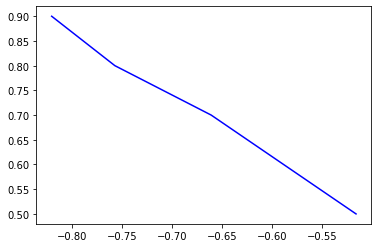

In [58]:
xdata = Gy
ydata = c0c2
y = func(xdata, 0.27)
popt, pcov = curve_fit(func, xdata, ydata)

plt.plot(xdata, ydata, 'b-', label='data')

In [59]:
popt, pcov

(array([0.24302337]), array([[0.00154575]]))

mean G = 20.839182816687785
a = 0.24302337
b = 0.7
hL = 0.034276090409539585


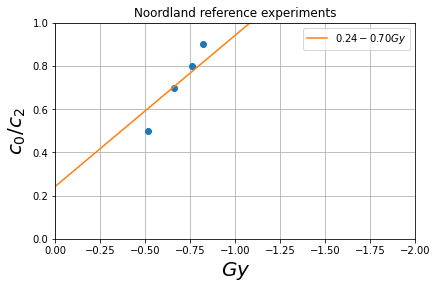

In [60]:
figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)
ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments")
ax.axis([-2,0,0,1])
ax.grid()

NL1204sel = NL1204D3Q3.iloc[1:] #select which dataset, leaving out the first datapoint where lam=0
P = NL1204sel.iloc[0].D/2
G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
print('mean G =', np.mean(G))
y = NL1204sel.D/2 - NL1204sel.am
Gy = G*y
c0c2 = 1 - NL1204sel.lam

Gyfit = np.linspace(-4,3,1000)
#in the fit i am leaving out the first datapoint, because it is already at c0/c2=1 (or lam=0)
a = 0.24302337
b = 0.7
#p = np.polyfit(Gy, c0c2, 1)
#[a, b] = p[1], abs(p[0])
c0c2fit = a - b*Gyfit
print('a =', a)
print('b =', b)
hL = 1/(2*np.mean(G)*b)
print('hL =', hL)

c0c2comp = a - b*Gy

ax.plot(Gy, c0c2, 'o')
ax.plot(Gyfit, c0c2fit, label="${0:.2f}-{1:.2f}Gy$".format(a,b))

ax.legend()
ax.invert_xaxis()
plt.show()

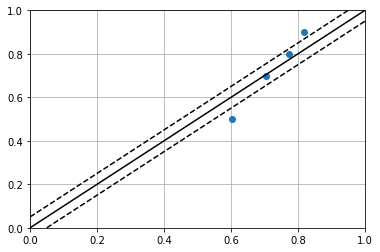

In [67]:
plt.plot(c0c2comp, c0c2, 'o')
plt.gca().axline((1, 1), slope=1, color='k')
plt.gca().axline((1.05, 1), slope=1, linestyle='--', color='k')
plt.gca().axline((1, 1.05), slope=1, linestyle='--', color='k')

plt.axis([0,1,0,1])
plt.grid()

# Coordinate transformation

### Using $y = P-h_r$

G = 42.95664676863856
a = 0.25695437053325965
b = -0.6270945239279453
hL = 0.018561224489795903
a' = 0.4218801539307301
b' = -0.6270945239279458


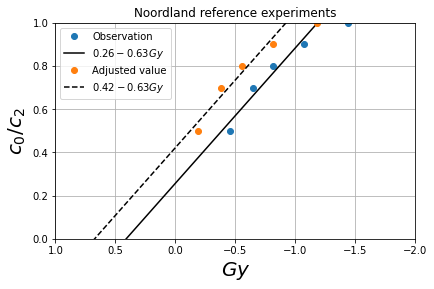

In [23]:
figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)
ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments")
ax.axis([-2,1,0,1])
ax.grid()

NL1204sel = NL1204D3Q1
P = NL1204sel.iloc[0].D/2
G = np.mean(pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)) #taking the mean because the values for g' are not constant (but close to each other)
print('G =', G)
y = NL1204sel.D/2 - NL1204sel.hr
Gy = G*y
c0c2 = 1 - NL1204sel.lam

Gyfit = np.linspace(-4,3,1000)
[b,a] = np.polyfit(Gy[1:], c0c2[1:], 1)
c0c2fit = a + b*Gyfit
print('a =', a)
print('b =', b)
hL = 1/(2*G*abs(b))
print('hL =', hL)

Gyp = transform(Gy, G, hL, P)
[bp,ap] = np.polyfit(Gyp[1:], c0c2[1:], 1)
c0c2fitp = ap + bp*Gyfit
print("a' =", ap)
print("b' =", bp)

ax.plot(Gy, c0c2, 'o', label="Observation")
ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$".format(a,abs(b)))

ax.plot(Gyp, c0c2, 'o', label="Adjusted value")
ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy$".format(ap,abs(bp)))

ax.legend()
ax.invert_xaxis()
plt.show()

In [24]:
reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]
amodel = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data)),
                       'ap':np.zeros(len(reference_data)),
                       'G':np.zeros(len(reference_data))})

i = 0
for NL1204sel in reference_data:
    P = NL1204sel.iloc[0].D/2
    G = np.mean(pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)) #taking the mean because the values for g' are not constant (but close to each other)
    y = NL1204sel.D/2 - NL1204sel.hr
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    [b,a] = np.polyfit(Gy[1:], c0c2[1:], 1)
    hL = 1/(2*G*abs(b))

    Gyp = transform(Gy, G, hL, P)
    [bp,ap] = np.polyfit(Gyp[1:], c0c2[1:], 1)

    amodel.P[i] = P
    amodel.hL[i] = hL
    amodel.a[i] = a
    amodel.b[i] = b
    amodel.ap[i] = ap
    amodel.G[i] = G
    i += 1

### Using $y = P-a_m$

G = 20.87673902376427
a = -0.20500000000000035
b = -1.3499147615793095
hL = 0.01774193548387095
a' = -0.07863636363636455
b' = -1.3499147615793081


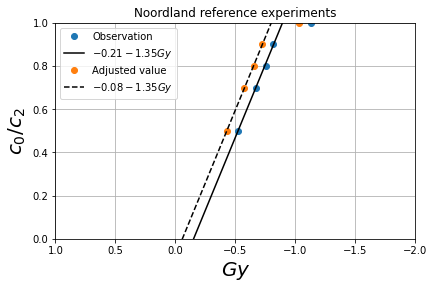

In [25]:
figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)
ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments")
ax.axis([-2,1,0,1])
ax.grid()

NL1204sel = NL1204D3Q3
P = NL1204sel.iloc[0].D/2
G = np.mean(pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)) #taking the mean because the values for g' are not constant (but close to each other)
print('G =', G)
y = NL1204sel.D/2 - NL1204sel.am
Gy = G*y
c0c2 = 1 - NL1204sel.lam

Gyfit = np.linspace(-4,3,1000)
[b,a] = np.polyfit(Gy[1:], c0c2[1:], 1)
c0c2fit = a + b*Gyfit
print('a =', a)
print('b =', b)
hL = 1/(2*G*abs(b))
print('hL =', hL)

Gyp = transform(Gy, G, hL, P)
[bp,ap] = np.polyfit(Gyp[1:], c0c2[1:], 1)
c0c2fitp = ap + bp*Gyfit
print("a' =", ap)
print("b' =", bp)

ax.plot(Gy, c0c2, 'o', label="Observation")
ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$".format(a,abs(b)))

ax.plot(Gyp, c0c2, 'o', label="Adjusted value")
ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy$".format(ap,abs(bp)))

ax.legend()
ax.invert_xaxis()
plt.show()

In [26]:
reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]
amodel2 = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data)),
                       'ap':np.zeros(len(reference_data)),
                       'G':np.zeros(len(reference_data))})

i = 0
for NL1204sel in reference_data:
    P = NL1204sel.iloc[0].D/2
    G = np.mean(pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)) #taking the mean because the values for g' are not constant (but close to each other)
    y = NL1204sel.D/2 - NL1204sel.am
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    [b,a] = np.polyfit(Gy[1:], c0c2[1:], 1)
    hL = 1/(2*G*abs(b))

    Gyp = transform(Gy, G, hL, P)
    [bp,ap] = np.polyfit(Gyp[1:], c0c2[1:], 1)

    amodel2.P[i] = P
    amodel2.hL[i] = hL
    amodel2.a[i] = a
    amodel2.b[i] = b
    amodel2.ap[i] = ap
    amodel2.G[i] = G
    i += 1

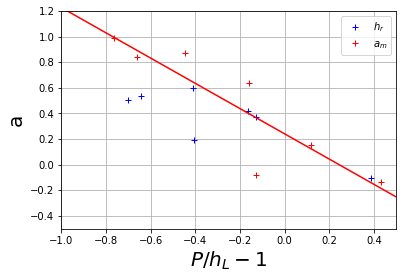

In [27]:
#plt.plot(amodel.P/amodel.hL-1, amodel.a, 'ob')
plt.plot(amodel.P/amodel.hL-1, amodel.ap, '+b', label="$h_r$")
#plt.plot(amodel2.P/amodel2.hL-1, amodel2.a, 'or')
plt.plot(amodel2.P/amodel2.hL-1, amodel2.ap, '+r', label="$a_m$")

phL_1 = np.linspace(-10,10,1000)
[p0, p1] = np.polyfit(amodel2.P/amodel2.hL-1, amodel2.ap, 1)
apredict = p0*phL_1 + p1
plt.plot(phL_1, apredict, 'r')

plt.gca().set(xlabel="$P/h_L-1$", ylabel="a")
plt.axis([-1,0.5,-0.5,1.2])
plt.grid()
plt.legend()

In [28]:
amodel.b

0   -0.627095
1   -0.918287
2   -0.778911
3   -0.815377
4   -0.519318
5   -0.671023
6   -0.648374
Name: b, dtype: float64

In [29]:
b = 0.92
K = 1/(2*b)

NL1204sel = NL1204D3Q3

P = NL1204sel.D/2
G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
y = P - NL1204sel.am
hL = K/G
a = np.interp(P/hL-1, phL_1, apredict)

c0c2_observed = 1 - NL1204sel.lam
c0c2_prediction = a - b*G*y


[Text(0.5, 0, 'predicted $c_0/c_2$'), Text(0, 0.5, 'observed $c_0/c_2$')]

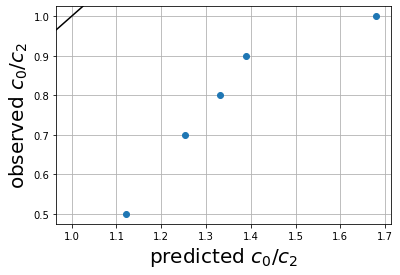

In [30]:
plt.plot(c0c2_prediction, c0c2_observed, 'o')
plt.gca().axline((1, 1), slope=1, color='k')
plt.grid()
#plt.axis([0,1,0,1])
plt.gca().set(xlabel="predicted $c_0/c_2$", ylabel="observed $c_0/c_2$")

In [31]:
amodel2.b

0   -0.839725
1   -1.349915
2   -0.736321
3   -0.642499
4   -0.536482
5   -0.644881
6   -0.605178
Name: b, dtype: float64

In [32]:
b = np.mean(abs(amodel2.b))
K = 1/(2*b)
G = pow(NL1204D3Q1.iloc[0].rhofrac*9.81/NL1204D3Q1.iloc[0].q**2,1/3)
P = NL1204D3Q1.iloc[0].D/2
hL = K/G
print('P/hL-1 = ',P/hL-1)
a = np.interp(P/hL-1, phL_1, apredict)
print('a =', a)
c0c2_observed = 1 - NL1204D3Q1.lam
c0c2_prediction = a - b*pow(NL1204D3Q1.rhofrac*9.81/NL1204D3Q1.q**2,1/3)*(NL1204D3Q1.D/2-NL1204D3Q1.am)

P/hL-1 =  0.018717032398716693
a = 0.22148660019582211


(0.0, 1.1, 0.0, 1.1)

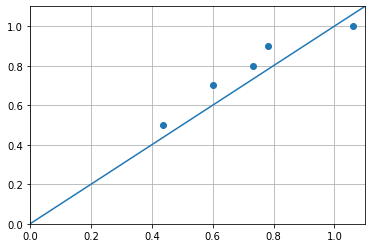

In [33]:
plt.plot(c0c2_prediction, c0c2_observed, 'o')
plt.gca().axline((1, 1), slope=1)
plt.grid()
plt.axis([0,1.1,0,1.1])